__языковая модель__

charCNN-LSTM

генерирует следующий символ по предыдущим

In [1]:
import gzip
import re
import numpy as np
from numpy import random as rng
import pandas as pd
from tqdm import tqdm
from os.path import join as pjoin

In [2]:
# from utils.helpers import ppr
# from utils.helpers import replace_patterns

In [ ]:
def ppr(df): return print(len(df))

def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

In [3]:
np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth=200 

tqdm.pandas()

/usr/lib/python3.9/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
FOLDER_RESULT='result'

In [ ]:
!mkdir result

## загружаем данные

In [7]:
FILE_DATA = '../data/dostoevsky-besy-p3.txt.gz'
with gzip.open(FILE_DATA,'rt',encoding='utf-8') as f: text = f.read()     
ppr(text)    

записей: 465 595


In [8]:
print(text[:200]+'...')

БЕСЫ

Федор Михайлович Достоевский





ЧАСТЬ ВТОРАЯ



ГЛАВА ПЕРВАЯ



Ночь



I



Прошло восемь дней. Теперь, когда уже все прошло, и я пишу хронику, мы уже знаем в чем дело; но тогда мы еще ничего...


In [9]:
pat = [
    [r'([\.!\?;]+)',r'\1\n'],
    ['\n+','\n'],
]

data = pd.DataFrame({'line':replace_patterns(text,pat).split('\n')})
data.head(30)

,line
0,БЕСЫ
1,Федор Михайлович Достоевский
2,ЧАСТЬ ВТОРАЯ
3,ГЛАВА ПЕРВАЯ
4,Ночь
5,I
6,Прошло восемь дней.
7,"Теперь, когда уже все прошло, и я пишу хронику, мы уже знаем в чем дело;"
8,"но тогда мы еще ничего не знали, и естественно, что нам представлялись странными разные вещи."
9,По крайней мере мы со Степаном Трофимовичем в первое время заперлись и с испугом наблюдали издали.


In [10]:
data = data.iloc[6:]

In [11]:
data['line'] = data['line'].str.strip()
data['line'].str.len().describe().astype(int)

count    6828
mean       66
std        59
min         0
25%        26
50%        49
75%        89
max       584
Name: line, dtype: int64

In [12]:
ppr(data)
data = data[ data['line'].str.len()>0 ] 
ppr(data)

записей: 6 828
записей: 6 827


In [13]:
# data[data['line'].str.len()<1]

## очистка данных

In [14]:
def tokenize(s): 
    return [ w.strip() for w in re.split(r'\b| ',s) if w.strip() ]

In [15]:
pat = [
    [r'"|\'',' '],
    [r'\(|\)',','],
    ['\d+','D'],
    ['[a-z•^]+',' '],
    ['\n',' '],
    [',',' , '],
    ['-',' - '],
    [r' +',' ',],
]

data['line'] = data['line']\
    .progress_apply(lambda s: replace_patterns(s.lower(),pat).strip() )\
    .progress_apply(tokenize) 

100%|██████████| 6827/6827 [00:00<00:00, 102599.94it/s]


In [16]:
%xdel text

In [17]:
ppr(data)
data.sample(4)

записей: 6 827


,line
3776,"[мало, ли, мы, их, видали, .]"
4375,"[-, да, ,, но, у, вас, моя, рукопись, .]"
5775,"[высокий, уровень, наук, и, талантов, доступен, только, высшим, способностям, ,, не, надо, высших, способностей, !]"
4932,"[все, это, материал, ,, который, надо, организовать, да, и, убираться, .]"


In [18]:
ppr(data)
data = data[ data['line'].str.len()>0 ] 
ppr(data)

записей: 6 827
записей: 6 791


In [19]:
# data[data['line'].str.len()<1]

## формируем словари

In [20]:
words = sorted(set(sum(data['line'].values.tolist(),[]) )) # список слов
ppr(words)
# words

записей: 15 171


In [21]:
vocabulary = { a:i+1 for i,a in enumerate(words) } # словарь
vocabulary['PAD']=0
ppr(vocabulary)
# vocabulary

записей: 15 172


In [22]:
# ord?

# [ chr(i) for i in range(0,100) ] 
# [ [i,chr(i)] for i in range(100,200) ] 
# [ [i,chr(i)] for i in range(200,300) ] 
# [ [i,chr(i)] for i in range(300,400) ] 
# [ [i,chr(i)] for i in range(500,600) ] 
# [ [i,chr(i)] for i in range(600,700) ] 
# [ [i,chr(i)] for i in range(700,800) ] 

In [23]:
abc = set(' '.join(words) ) # алфавит
abc = { a:i+1 for i,a in enumerate(sorted(abc)) }
zero_symbol = '\t'
abc[zero_symbol] = 0
ppr(abc)
# abc

записей: 42


In [24]:
# %xdel words

In [25]:
# voc_len = len(vocabulary)
# abc_len = len(abc)
# voc_len, len(words), abc_len, max(vocabulary.values()), max(abc.values())

----

In [26]:
words = pd.DataFrame({'word':words}) # список слов
max_word_len = words['word'].str.len().max() # максимальная длина слова
ppr(words)
# words.sample(3)
max_word_len

записей: 15 171


19

In [27]:
# дополняем слово до максимальной длины
def pad_word(w,max_word_len=max_word_len,zero_symbol=zero_symbol):
    return w+zero_symbol*(max_word_len-len(w))

# заменяем символы слова на последовательность номеров символов в алфавите 
def encode_abc(w,abc=abc ): 
    return list(map(abc.get,w))

# выполняем OHE номеров символов 
def encode_abc_bin(codes,abc_len=len(abc)):
    return np.array([ np.eye(abc_len,dtype=int)[c] for c in codes ], dtype=int)[np.newaxis,:]


In [28]:
# w = 'символы'
# encode_abc_bin(encode_abc( pad_word(w) )).shape
# w+zero_symbol*(max_word_len-len(w))

In [29]:
words['code_char_bin_pad'] = words['word']\
                 .progress_apply(pad_word)\
                 .progress_apply(encode_abc)\
                 .progress_apply(encode_abc_bin)

100%|██████████| 15171/15171 [00:00<00:00, 19961.42it/s]


In [30]:
np.vstack(words['code_char_bin_pad']).shape

(15171, 19, 42)

In [31]:
# алфавит
ppr(abc)
# abc

записей: 42


In [32]:
# словарь
ppr(vocabulary)
# abc

записей: 15 172


In [33]:
# таблица кодов слов
ppr(words)
words.sample(3)

записей: 15 171


,word,code_char_bin_pad
10343,промокло,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2644,дикое,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,..."
4590,клянусь,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,..."


## кодируем текст

In [34]:
# заменяем слова на последовательность номеров слов в словаре 
data['seq_code_word'] = data['line'].progress_apply(lambda s: [ vocabulary[w] for w in s ])

100%|██████████| 6791/6791 [00:00<00:00, 478787.02it/s]


In [35]:
# data['seq_code_word'].str.len().plot.hist()
data['seq_code_word'].str.len().describe([.1,.25,.5,.75,.9,.95,.99]).astype(int)

count    6791
mean       13
std        11
min         1
10%         4
25%         6
50%        10
75%        18
90%        28
95%        35
99%        54
max       111
Name: seq_code_word, dtype: int64

In [36]:
# последовательность слов (основной текст)
ppr(data)
data.sample(3)

записей: 6 791


,line,seq_code_word
2122,"[он, положил, про, себя, ,, что, тот, бесстыдный, трус, ;]","[7327, 8923, 10176, 11639, 6, 14808, 13431, 359, 13541, 12]"
6152,"[и, вот, ,, к, удивлению, моему, ,, он, и, тут, был, не, уверен, :, участвует, он, или, нет, в, каком, -, нибудь, тайном, обществе, .]","[3985, 1445, 6, 4375, 13765, 5618, 6, 7327, 3985, 13565, 743, 6266, 13642, 11, 14232, 7327, 4156, 6626, 766, 4438, 7, 6683, 13153, 7085, 8]"
6559,"[мы, просидели, так, минут, десять, .]","[5764, 10390, 13162, 5540, 2618, 8]"


## собираем датасет

In [37]:
hist_deep = 5 # глубина истории контекста

In [38]:
data['seq_code_word'].str.len().describe([.1,.25,.5,.75,.9,.95,.99]).astype(int)

count    6791
mean       13
std        11
min         1
10%         4
25%         6
50%        10
75%        18
90%        28
95%        35
99%        54
max       111
Name: seq_code_word, dtype: int64

In [39]:
ppr(data)
# data = data[ data['seq_code_word'].str.len()>hist_deep ] 
data = data[ data['seq_code_word'].str.len().between(hist_deep+1,data['seq_code_word'].str.len().quantile(.95)) ] 
ppr(data)

записей: 6 791
записей: 5 308


In [40]:
# s = data.sample()['seq_code_word'].values[0]
# len(s)
# hist_deep

In [41]:
# [ контекст, слово ]
def pack_history(s,hd=hist_deep):
    return [ [ s[i-hd:i], s[i] ] for i in range(hd,len(s)) ] 

# pack_history(s)

In [42]:
d = data['seq_code_word'].progress_apply(pack_history)
d = pd.DataFrame( sum(d.values.tolist(),[]), columns=['x_context','x'] )
ppr(d)
d.sample(3)

100%|██████████| 5308/5308 [00:00<00:00, 61592.38it/s]


записей: 60 804


,x_context,x
42751,"[15118, 3957, 6, 14808, 5764]",5789
10091,"[4028, 2027, 7477, 11343, 3012]",6
1149,"[13334, 9986, 8806, 3985, 8965]",7800


In [43]:
x = d['x'].values # номер слова
x_context = np.vstack(d['x_context'].values) # контекст слова
x.shape, x_context.shape

((60804,), (60804, 5))

In [44]:
%xdel d

## модель

In [45]:
# import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

In [46]:
# from utils.tf_helpers import tf_info
# from IPython.display import display, HTML
# display(HTML(tf_info()))

tensorflow,2.3.1
device,0
name,GeForce GTX 1060 6GB
pci bus id,0000:01:00.0
compute capability,6.1


---

In [47]:
x_context.shape

(60804, 5)

In [48]:
# бинарные коды слов
# [ номер слова в словаре, номер символа в слове, номер символа в алфавите ]
words_char_code_bin_pad = np.vstack(words['code_char_bin_pad'].values.tolist() )
words_char_code_bin_pad.shape

(15171, 19, 42)

In [49]:
# добавляем код "нулевого" слова (PAD)
_,j,k = words_char_code_bin_pad.shape
words_char_code_bin_pad = np.vstack([
   np.zeros([1,j,k]),
   words_char_code_bin_pad
])

words_char_code_bin_pad.shape

(15172, 19, 42)

In [50]:
voc_len = len(vocabulary) # размер словаря
abc_len = len(abc) # размер алфавита
hist_deep = x_context.shape[1] # глубина контекста
word_len = words_char_code_bin_pad.shape[1] # максимальная длина слова 

code_len = 1024 # размер внутреннего представления контекста

hist_deep, word_len, voc_len, abc_len, code_len, 

(5, 19, 15172, 42, 1024)

In [51]:
model_name='charCNN2-BiLSTM'

i = Input(shape=(None, word_len, abc_len))
o = Conv2D(filters=code_len,kernel_size=5,strides=(1,1),padding='same', activation='relu')(i)
o = MaxPooling2D(pool_size=(word_len,1), data_format='channels_first')(o)
o = Reshape(target_shape=(hist_deep,code_len))(o)
o = Bidirectional(LSTM(code_len))(o)
o = Dense(voc_len, activation='softmax')(o)
model = Model(i,o)

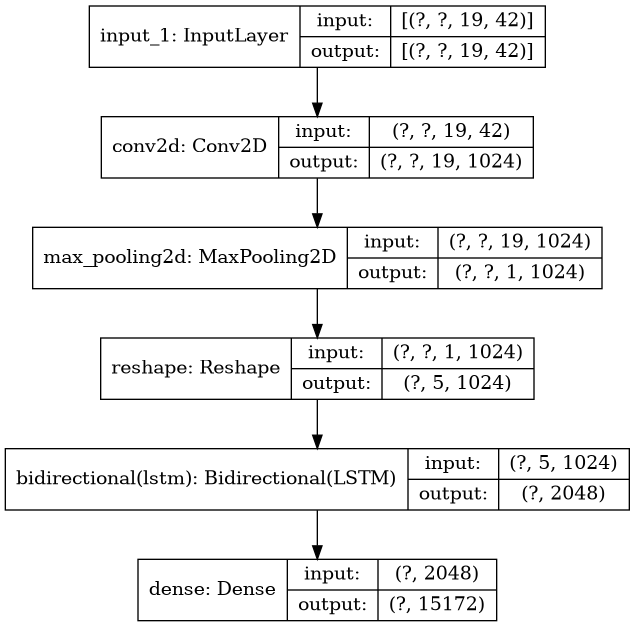

In [52]:
plot_model(model,to_file=pjoin(FOLDER_RESULT,model_name+'.png'), 
                show_layer_names=True, show_shapes=True )

In [53]:
with open( pjoin(FOLDER_RESULT,model_name+'.json'), 'wt') as f: f.write( model.to_json() )

## обучаем модель

In [54]:
learning_rate = 1e-3

optimizer=Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])

In [55]:
# преобразовать весь датасет в матрицы OHE займёт очень много памяти
# будем делать это в процессе формирования batch
# построим генератор батчей

# x - номера слов, 
# xc- цепочки номеров слов контекста для x
# batch_size - размер пакета данных
# ccb - матрицы кодов слов (OHE символов в словах, дополненные нулями до единого размера)
# voc_len - количество слов в словаре
def data_gen(x,xc,batch_size,ccb=words_char_code_bin_pad,voc_len=voc_len):
    bc = np.ceil(x.shape[0]/batch_size).astype(int) # количество пакетов данных
    while True:
        # перемешиваем номера примеров
        rand_idx = rng.permutation(range(x.shape[0]))
        # делим список индексов на части
        batches_idx = np.array_split(rand_idx,bc)
        # последовательно формируем и выдаём пакеты данных
        for ii in batches_idx:
            yield  ccb[xc[ii,:]], np.eye(voc_len,dtype=int)[x[ii]]

In [56]:
%%time 

n_epochs = 64
batch_size = 2048

hist = model.fit(
    data_gen(x,x_context,batch_size),
    steps_per_epoch = x.shape[0]//batch_size,
    epochs = n_epochs
)

Epoch 1/64
29/29 [==============================] - 27s 941ms/step - loss: 7.5993 - accuracy: 0.0630
Epoch 2/64
29/29 [==============================] - 27s 923ms/step - loss: 6.8694 - accuracy: 0.1028
Epoch 3/64
29/29 [==============================] - 27s 920ms/step - loss: 6.7328 - accuracy: 0.1117
Epoch 4/64
29/29 [==============================] - 27s 921ms/step - loss: 6.6295 - accuracy: 0.1124
Epoch 5/64
29/29 [==============================] - 27s 921ms/step - loss: 6.5030 - accuracy: 0.1212
Epoch 6/64
29/29 [==============================] - 27s 918ms/step - loss: 6.2862 - accuracy: 0.1286
Epoch 7/64
29/29 [==============================] - 27s 917ms/step - loss: 6.1176 - accuracy: 0.1330
Epoch 8/64
29/29 [==============================] - 27s 917ms/step - loss: 5.9890 - accuracy: 0.1366
Epoch 9/64
29/29 [==============================] - 27s 919ms/step - loss: 5.7865 - accuracy: 0.1412
Epoch 10/64
29/29 [==============================] - 27s 919ms/step - loss: 5.6340 - accura

In [57]:
model.save_weights( pjoin(FOLDER_RESULT,model_name+'-%02d.tf'%(n_epochs) ), save_format='tf') 

---

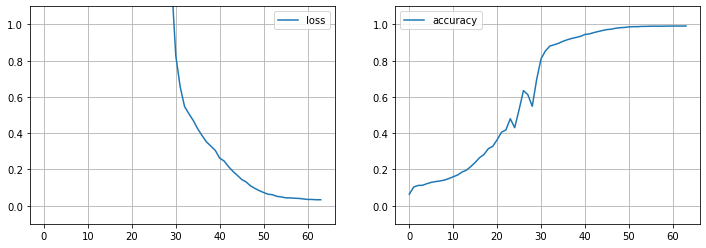

In [58]:
from matplotlib import pyplot as plt

k = hist.history.keys()

w,h = 6,4

fig,ax = plt.subplots(1,len(k),figsize=(w*len(k),h))
for i,n in enumerate(k):
    ax[i].plot(hist.history[n],label=n)
    ax[i].grid(True)
    ax[i].legend()
    ax[i].set_ylim([-.1,1.1])

## тестируем

In [59]:
# !ls result

In [60]:
# from tensorflow.keras.models import model_from_json
# # from tensorflow.keras.models import load_model

# fname='result/charCNN-BiLSTM.json'
# with open( fname, 'rt') as f: model = model_from_json(f.read())
# #model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

# fname = 'result/charCNN-BiLSTM-64.tf'
# model.load_weights( fname )     

In [61]:
def encode_str(s): 
    return np.vstack([
        encode_abc_bin(encode_abc(pad_word(w)))
        for w in tokenize(s) 
    ])[np.newaxis,:]

In [62]:
vocabulary_inv = { vocabulary[k]:k for k in vocabulary } # декодер слов

In [66]:
# начальный контекст
s = data['line'].apply(' '.join).sample().values[0]
s = ' '.join(tokenize(s)[:hist_deep])
s

', но тотчас же преобидно'

In [67]:
o = s + ' | ' # результат

for i in range(30):
    t = encode_str(s)
    p = model.predict(t)
    r = np.argmax(p)
    w = vocabulary_inv[r]
    s = ' '.join(tokenize(s)[1:] + [ w ])
    o += ' '+w

o

', но тотчас же преобидно |  перескочит в гаденький вальс . такого в которую вечером на бывал , а уже перестает над стол . таких совершенно гостя , но когда она тотчас ; казалось , вы'

In [68]:
s

'тотчас ; казалось , вы'